In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pickle
import sklearn
from sklearn.utils import class_weight
import time
from sklearn import metrics
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
%run SharedFunctions.ipynb

In [3]:
data = pd.read_csv('data/undersampled.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)


In [4]:
data.drop(columns=['Unnamed: 0.1'], inplace=True)

In [5]:
data.shape

(44936, 9)

In [6]:
data[data['target']==0].shape
data[data['target']==1].shape

(22468, 9)

In [7]:
test_size = int(0.33*data.shape[0])
train_size = data.shape[0] - test_size

validation_size = int(0.2*train_size)
train_size -= validation_size

In [8]:
train_size, test_size, validation_size

(24087, 14828, 6021)

In [9]:
validation_data = data[:validation_size]
train_data = data[validation_size : train_size+validation_size]
test_data = data[train_size + validation_size: ]

In [10]:
train_data.shape, test_data.shape, validation_data.shape

((24087, 9), (14828, 9), (6021, 9))

In [11]:
# uzima se recimo 20000 najfrekventinijh reci
max_features = 20000

# max duzina
max_len = 100

In [12]:
word_index, tokenizer = get_vocabulary(max_features, train_data, 'tokenizer_binary.pickle')

In [13]:
print('Broj jedinstvenih reci:', len(word_index))

Broj jedinstvenih reci: 58383


In [14]:
X_train = to_sequence(train_data['comment_text'], max_len, tokenizer)
X_test = to_sequence(test_data['comment_text'], max_len, tokenizer)
X_validation = to_sequence(validation_data['comment_text'], max_len, tokenizer)

In [15]:
y_train = train_data['target']
y_test = test_data['target']
y_validation = validation_data['target']

In [16]:
embedding_matrix = create_embedding_matrix(word_index, max_len)

In [17]:
kernel_size = 3
pool_size = 3
filters = 32
dropout_rate = 0.4

In [18]:
binary_model = create_model(num_of_classes = 2, num_of_features = max_features, embedding_dim = 100, 
                kernel_size = kernel_size, pool_size = pool_size, filters = filters, 
                dropout_rate = dropout_rate, maxlen = max_len, embedding_matrix = embedding_matrix)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 32)           9632      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 33, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 33, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 32)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0

In [19]:
lr = 0.001

binary_model.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=[f1_m, recall_m, precision_m, 'acc'])

In [20]:
weights = get_weights(y_train)
weights

{0: 1.009090909090909, 1: 0.9910714285714286}

In [21]:
epochs = 10
batch_size = 128

In [22]:
start = time.time()    

binary_history = binary_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                                 validation_data=(X_validation, y_validation), class_weight=weights)
                                 #,callbacks=[early_stop]
                                 
print('Trajanje obucavanja modela binarne klasifikacije: ', time.time() - start)

Epoch 1/10
189/189 [==============================] - 7s 36ms/step - loss: 0.4994 - f1_m: 0.7716 - recall_m: 0.8047 - precision_m: 0.7607 - acc: 0.7698 - val_loss: 0.3826 - val_f1_m: 0.8552 - val_recall_m: 0.8896 - val_precision_m: 0.8277 - val_acc: 0.8550
Epoch 2/10
189/189 [==============================] - 6s 33ms/step - loss: 0.3571 - f1_m: 0.8658 - recall_m: 0.8600 - precision_m: 0.8749 - acc: 0.8664 - val_loss: 0.3258 - val_f1_m: 0.8791 - val_recall_m: 0.8572 - val_precision_m: 0.9044 - val_acc: 0.8801
Epoch 3/10
189/189 [==============================] - 6s 33ms/step - loss: 0.3188 - f1_m: 0.8782 - recall_m: 0.8627 - precision_m: 0.8976 - acc: 0.8805 - val_loss: 0.3009 - val_f1_m: 0.8925 - val_recall_m: 0.8859 - val_precision_m: 0.9015 - val_acc: 0.8914
Epoch 4/10
189/189 [==============================] - 6s 33ms/step - loss: 0.2921 - f1_m: 0.8901 - recall_m: 0.8738 - precision_m: 0.9093 - acc: 0.8916 - val_loss: 0.2844 - val_f1_m: 0.8954 - val_recall_m: 0.8750 - val_precision_

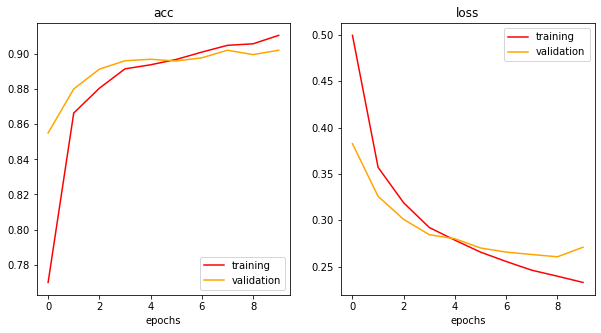

In [23]:
plot_graphs(binary_history, ['acc', 'loss'])

In [24]:
scores = binary_model.evaluate(X_test, y_test)

464/464 [==============================] - 2s 5ms/step - loss: 0.2708 - f1_m: 0.8953 - recall_m: 0.9169 - precision_m: 0.8802 - acc: 0.8978


In [29]:
y_pred = binary_model.predict(X_test)

label = [int(score > 0.5) for score in y_pred]

In [30]:
cf = metrics.confusion_matrix(y_test, label)

In [31]:
cf

array([[6616,  905],
       [ 610, 6697]], dtype=int64)

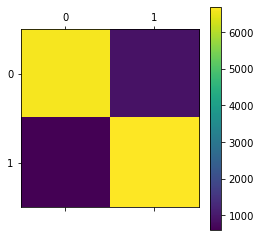

In [32]:
plt.matshow(cf)
plt.colorbar()
plt.show()